# Задача регрессии мультивариативного временного ряда

In [1]:
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import os
import torch.nn as nn
import torch
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
from tqdm import tqdm
from torch.optim import Adam
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from torch.utils.data import DataLoader, TensorDataset
from statsmodels.tsa.vector_ar.var_model import VAR

Минутка считывания данных и небольшого препроцессинга

In [2]:
def smape( data , pred ):
 return 1/ len (data) * np.sum (2 * np.abs (pred-data) / (np.abs (data) + np.abs (pred)))

In [3]:
data = pd.read_csv('powerconsumption.csv')

Сразу проверим что нет проблем со снятием временных меток

In [43]:
# Разница между соседними значениями в столбце timestamp
time_diff = pd.to_datetime(data['Datetime']).diff()

# Проверка, есть ли значения, отличающиеся от 10 минут
result = (time_diff == pd.Timedelta(minutes=10)).all()
result

False

Проблем нет, все промежутки по 10 минут.

In [4]:
data.set_index('Datetime', inplace=True)

In [5]:
data.index = pd.to_datetime(data.index)

In [46]:
data

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259


In [6]:
data.describe()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360


Проверим данные на наличие пропусков.

In [7]:
missing_values = data.isnull().sum()
missing_values = pd.DataFrame(missing_values[missing_values>0])
missing_values

,0


Пропусков нет, храни боже этот датасет.(Почти в рифму)

Я его не специально так искал, честно. Мне просто очень повезло.

In [6]:
df = data.copy()

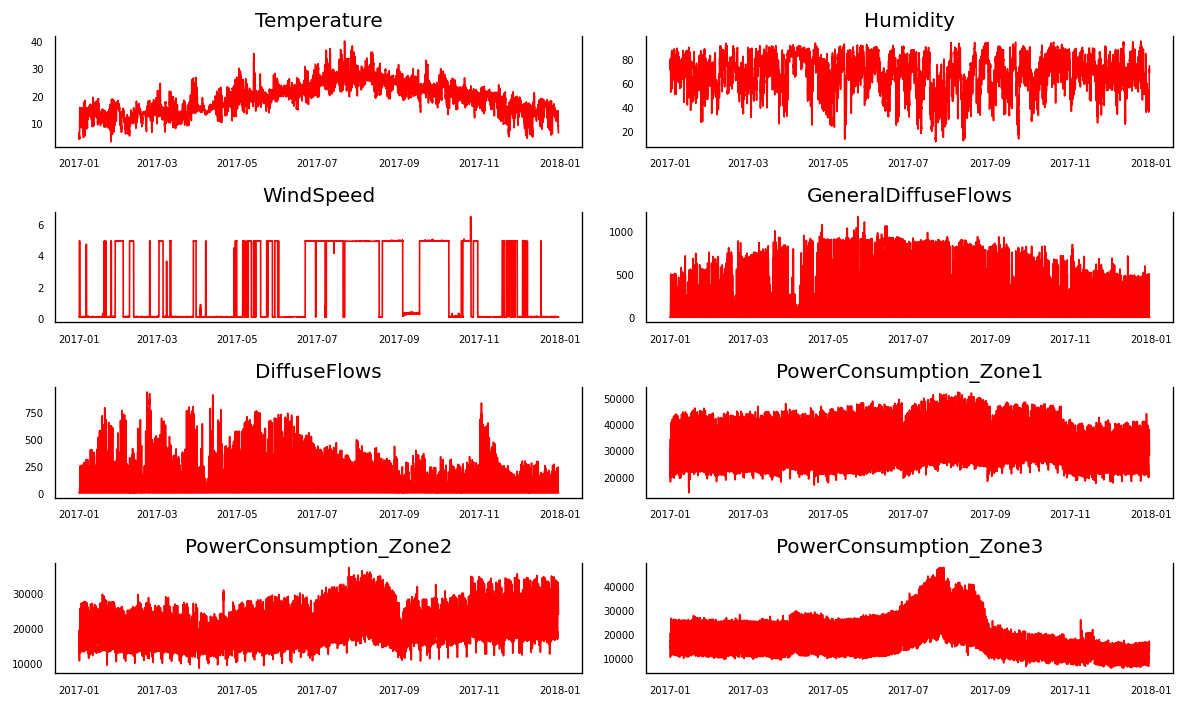

In [8]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

Красивые графики, на глазок я бы даже сказал что они стационарные. Но метод пристального взгляда не очень точный, так что проверим нормально.

In [19]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = df
coint_johansen(johan_test_temp,-1,1).eig

array([5.36854899e-02, 3.64325525e-02, 3.18059765e-02, 1.07673158e-02,
       6.13204498e-03, 2.97668183e-03, 1.89401605e-03, 1.78586333e-05])

Тест Йохансена показал собственные значения меньше единички, так что со стационарностью проблем нет.

Но для уверенности прогоним данные ещё и через тест Дики-Фуллера.

In [28]:
def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [47]:
for col in df.columns:
    if col != 'Date':
        df_test(col, data[col])

Тест Дики-Фуллера ряда Temperature:
Test Statistic                -9.459828e+00
p-value                        4.384186e-16
#Lags Users                    5.800000e+01
Number of Observations Used    5.235700e+04
Critical Value (1%)           -3.430475e+00
Critical Value (5%)           -2.861595e+00
Critical Value (10%)          -2.566799e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда Humidity:
Test Statistic                -1.718425e+01
p-value                        6.616076e-30
#Lags Users                    5.800000e+01
Number of Observations Used    5.235700e+04
Critical Value (1%)           -3.430475e+00
Critical Value (5%)           -2.861595e+00
Critical Value (10%)          -2.566799e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда WindSpeed:
Test Statistic                -6.982260e+00
p-value                        8.135108e-10
#Lags Users                    5.700000e+01
Number of Observations Used    5.23

Глаз не обманул, все ряды стационарные.Это здорово.

Для полного счастья осталось разве что причинность про Грейнжеру проверить.

In [49]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in tqdm(df.columns):
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
warnings.filterwarnings("ignore")
j_test = grangers_causation_matrix(data, variables = data.columns)
warnings.filterwarnings("default")
j_test

100%|██████████| 8/8 [01:02<00:00,  7.80s/it]


,Temperature_x,Humidity_x,WindSpeed_x,GeneralDiffuseFlows_x,DiffuseFlows_x,PowerConsumption_Zone1_x,PowerConsumption_Zone2_x,PowerConsumption_Zone3_x
Temperature_y,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
Humidity_y,0.0,1.0000,0.0402,0.0000,0.0000,0.0000,0.0,0.0
WindSpeed_y,0.0,0.2546,1.0000,0.5911,0.0015,0.0001,0.0,0.0
GeneralDiffuseFlows_y,0.0,0.0000,0.0021,1.0000,0.0000,0.0000,0.0,0.0
DiffuseFlows_y,0.0,0.0000,0.1024,0.0000,0.9404,0.0000,0.0,0.0
PowerConsumption_Zone1_y,0.0,0.0000,0.0000,0.0000,0.0000,1.0000,0.0,0.0
PowerConsumption_Zone2_y,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,0.0
PowerConsumption_Zone3_y,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,1.0


Ну что, переходим к моделям.

Но для начала разобъем выборку на train и test(Она же валидационная). (Понадобится несколько попозже)

In [7]:
train_data = df.drop(['PowerConsumption_Zone1','PowerConsumption_Zone2','PowerConsumption_Zone3'], axis = 1)

In [52]:
train_data

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
Datetime,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085
...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074


In [8]:
a = np.array(train_data)

In [9]:
tar_train = np.array(df['PowerConsumption_Zone1'][1:int(len(a)*0.8)+1])
tar_test = np.array(df['PowerConsumption_Zone1'][int(len(a)*0.8)+1:])

In [10]:
train = a[1:int(len(a)*0.8)+1]
test = a[int(len(a)*0.8)+1:]

# Нейронные сети. В следующих блоках попробуем предсказать нащ ряд с использованием моделей LSTM, GRU, RNN.

In [94]:
import numpy as np

feature_cols = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows']
target_col = 'PowerConsumption_Zone1'

X = df[feature_cols].values
Y = df[target_col].values

n_features = X.shape[1]
lookback = 30

X_organized, Y_organized = [], []
for i in range(0, X.shape[0]-lookback, 1):
    X_organized.append(X[i:i+lookback])
    Y_organized.append(Y[i+lookback])

X_organized, Y_organized = np.array(X_organized), np.array(Y_organized)
X_organized, Y_organized = torch.tensor(X_organized, dtype=torch.float32), torch.tensor(Y_organized, dtype=torch.float32)
X_train, Y_train, X_test, Y_test = X_organized[:45000], Y_organized[:45000], X_organized[45000:], Y_organized[45000:]

X_organized.shape, Y_organized.shape, X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([52386, 30, 5]),
 torch.Size([52386]),
 torch.Size([45000, 30, 5]),
 torch.Size([45000]),
 torch.Size([7386, 30, 5]),
 torch.Size([7386]))

Нормализация данных куда же без неё.

In [95]:
mean, std = Y_train.mean(), Y_train.std()

print("Mean : {:.2f}, Standard Deviation : {:.2f}".format(mean, std))
Y_train_scaled, Y_test_scaled = (Y_train - mean)/std , (Y_test-mean)/std

Mean : 32892.72, Standard Deviation : 7141.31


In [96]:
train_dataset = TensorDataset(X_train, Y_train_scaled)
test_dataset  = TensorDataset(X_test,  Y_test_scaled)

train_loader = DataLoader(train_dataset, shuffle=False, batch_size=32)
test_loader  = DataLoader(test_dataset,  shuffle=False, batch_size=32)

LSTM.

In [72]:
from torch.nn import functional as F

hidden_dim = 196
n_layers=2

class LSTMRegressor(nn.Module):
    def __init__(self):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, X_batch):
        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim), torch.randn(n_layers, len(X_batch), hidden_dim)
        output, (hidden, carry) = self.lstm(X_batch, (hidden, carry))
        return self.linear(output[:,-1])

In [73]:
lstm_regressor = LSTMRegressor()

lstm_regressor

LSTMRegressor(
  (lstm): LSTM(5, 196, num_layers=2, batch_first=True)
  (linear): Linear(in_features=196, out_features=1, bias=True)
)

In [103]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

def CalcValLoss(model, loss_fn, val_loader):
    with torch.no_grad():
        losses = []
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds.ravel(), Y)
            losses.append(loss.item())
        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))

def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            # X,Y = X.to('cpu'),Y.to('cpu')
            Y_preds = model(X)

            loss = loss_fn(Y_preds.ravel(), Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLoss(model, loss_fn, val_loader)

In [77]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = nn.MSELoss()
lstm_regressor = LSTMRegressor()
optimizer = Adam(lstm_regressor.parameters(), lr=learning_rate)

TrainModel(lstm_regressor, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 1407/1407 [01:00<00:00, 23.42it/s]


Train Loss : 0.173
Valid Loss : 0.119


100%|██████████| 1407/1407 [01:04<00:00, 21.67it/s]


Train Loss : 0.142
Valid Loss : 0.105


100%|██████████| 1407/1407 [01:06<00:00, 21.17it/s]


Train Loss : 0.138
Valid Loss : 0.099


100%|██████████| 1407/1407 [01:08<00:00, 20.42it/s]


Train Loss : 0.133
Valid Loss : 0.102


100%|██████████| 1407/1407 [01:10<00:00, 19.92it/s]


Train Loss : 0.130
Valid Loss : 0.110


100%|██████████| 1407/1407 [01:11<00:00, 19.73it/s]


Train Loss : 0.127
Valid Loss : 0.102


100%|██████████| 1407/1407 [01:12<00:00, 19.49it/s]


Train Loss : 0.125
Valid Loss : 0.092


100%|██████████| 1407/1407 [01:11<00:00, 19.80it/s]


Train Loss : 0.126
Valid Loss : 0.096


100%|██████████| 1407/1407 [01:12<00:00, 19.36it/s]


Train Loss : 0.125
Valid Loss : 0.087


100%|██████████| 1407/1407 [01:08<00:00, 20.41it/s]


Train Loss : 0.124
Valid Loss : 0.103


100%|██████████| 1407/1407 [01:07<00:00, 20.97it/s]


Train Loss : 0.123
Valid Loss : 0.096


100%|██████████| 1407/1407 [01:06<00:00, 21.02it/s]


Train Loss : 0.125
Valid Loss : 0.088


100%|██████████| 1407/1407 [01:07<00:00, 20.98it/s]


Train Loss : 0.123
Valid Loss : 0.089


100%|██████████| 1407/1407 [01:09<00:00, 20.21it/s]


Train Loss : 0.122
Valid Loss : 0.092


100%|██████████| 1407/1407 [01:11<00:00, 19.55it/s]


Train Loss : 0.121
Valid Loss : 0.088


In [78]:
test_preds = lstm_regressor(X_test) ## Make Predictions on test dataset
test_preds  = (test_preds*std) + mean

test_preds[:5]

tensor([[32136.2207],
        [32202.6348],
        [32310.8672],
        [32406.3379],
        [32687.9297]], grad_fn=<SliceBackward0>)

In [79]:
data_df_final = df[45000:].copy()

data_df_final["Zone 1 Power Consumption Prediction"] = [None]*lookback + test_preds.detach().numpy().squeeze().tolist()

data_df_final.tail()


,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Zone 1 Power Consumption Prediction
Datetime,,,,,,,,,
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,29743.126953
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,29005.033203
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,22644.513672
2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,22614.363281
2017-12-30 23:50:00,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820,22806.355469


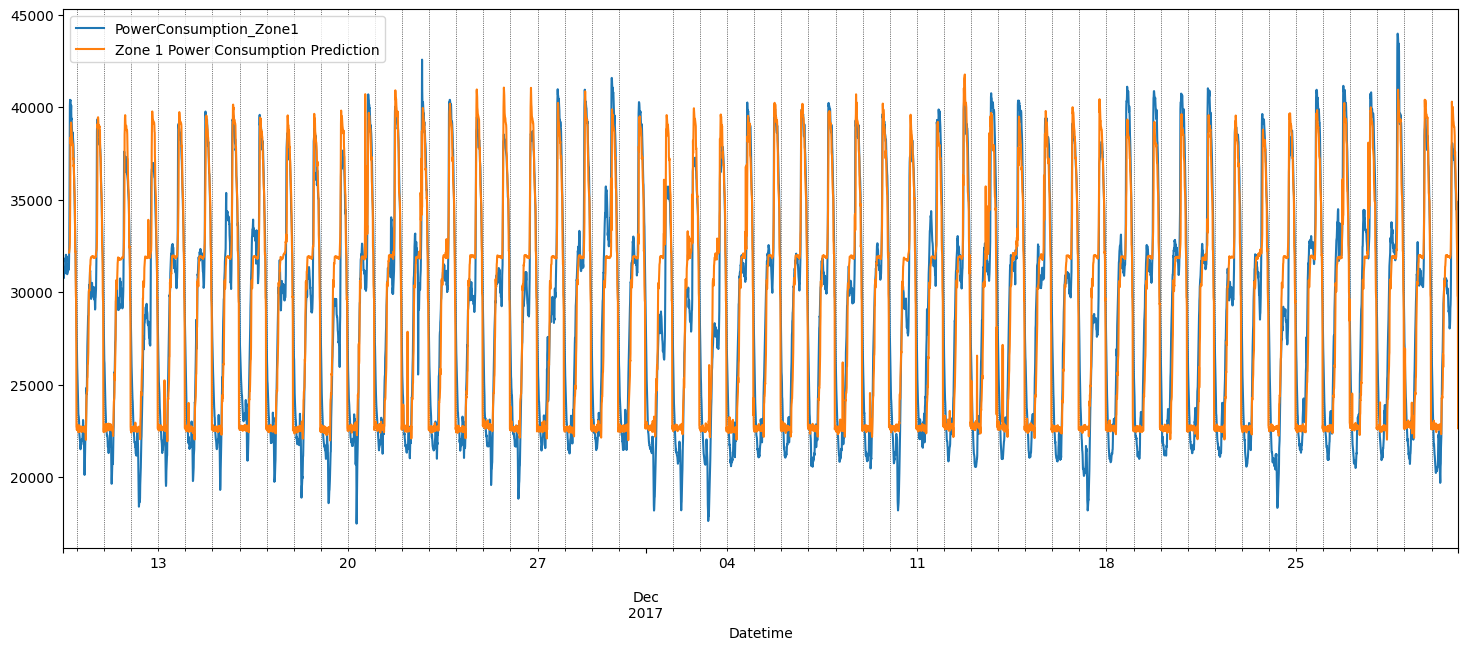

In [80]:
data_df_final.plot(y=["PowerConsumption_Zone1", "Zone 1 Power Consumption Prediction"],figsize=(18,7))
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

Ну в общем, очень даже неплохо. Принцип оно более или менее поняло.

In [81]:
print("RMSE:", np.sqrt(mean_squared_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:])))
print("MAPE:", mean_absolute_percentage_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("MAE:", mean_absolute_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("R2: ", r2_score(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("SMAPE: ", smape(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))

RMSE: 2131.6668749349433
MAPE: 0.057786438833399914
MAE: 1611.8001970678479
R2:  0.8772614496866169
SMAPE:  0.058264111388572556


: 

С метриками всё в целом неплохо. RMSE и MAE выглядят большими и страшными, но там и данные достаточно большие так что в целом неплохо. 

R2 ~0.88 это неплохо. MAPE и SMAPE в районе 5-6% Вообще шик.

In [118]:
from torch.nn import functional as F

hidden_dim = 256
n_layers=2

class GRURegressor(nn.Module):
    def __init__(self):
        super(GRURegressor, self).__init__()
        self.gru = nn.GRU(input_size=n_features, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, X_batch):
        hidden = torch.randn(n_layers, len(X_batch), hidden_dim)
        output, (hidden) = self.gru(X_batch, (hidden.detach()))
        return self.linear(output[:,-1])

In [119]:
gru_regressor = GRURegressor()

gru_regressor

GRURegressor(
  (gru): GRU(5, 256, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [121]:
from torch.optim import Adam

epochs = 10
learning_rate = 1e-3

loss_fn = nn.MSELoss()
gru_regressor = GRURegressor()
optimizer = Adam(gru_regressor.parameters(), lr=learning_rate)

TrainModel(gru_regressor, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 1407/1407 [01:07<00:00, 20.71it/s]


Train Loss : 0.191
Valid Loss : 0.103


100%|██████████| 1407/1407 [01:09<00:00, 20.36it/s]


Train Loss : 0.150
Valid Loss : 0.097


100%|██████████| 1407/1407 [01:10<00:00, 19.88it/s]


Train Loss : 0.146
Valid Loss : 0.096


100%|██████████| 1407/1407 [01:12<00:00, 19.52it/s]


Train Loss : 0.142
Valid Loss : 0.095


100%|██████████| 1407/1407 [01:10<00:00, 19.85it/s]


Train Loss : 0.140
Valid Loss : 0.101


100%|██████████| 1407/1407 [01:09<00:00, 20.11it/s]


Train Loss : 0.138
Valid Loss : 0.096


100%|██████████| 1407/1407 [01:08<00:00, 20.50it/s]


Train Loss : 0.137
Valid Loss : 0.094


100%|██████████| 1407/1407 [01:09<00:00, 20.36it/s]


Train Loss : 0.135
Valid Loss : 0.095


100%|██████████| 1407/1407 [01:09<00:00, 20.15it/s]


Train Loss : 0.135
Valid Loss : 0.099


100%|██████████| 1407/1407 [01:09<00:00, 20.17it/s]


Train Loss : 0.134
Valid Loss : 0.101


In [122]:
test_preds = gru_regressor(X_test) ## Make Predictions on test dataset
test_preds  = (test_preds*std) + mean

test_preds[:5]

tensor([[31082.1562],
        [31932.6445],
        [32504.6816],
        [32515.1914],
        [31511.5098]], grad_fn=<SliceBackward0>)

In [123]:
data_df_final = df[45000:].copy()

data_df_final["Zone 1 Power Consumption Prediction"] = [None]*lookback + test_preds.detach().numpy().squeeze().tolist()

data_df_final.tail()


,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Zone 1 Power Consumption Prediction
Datetime,,,,,,,,,
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,31295.587891
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,26955.300781
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,23680.296875
2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,23254.492188
2017-12-30 23:50:00,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820,23542.027344


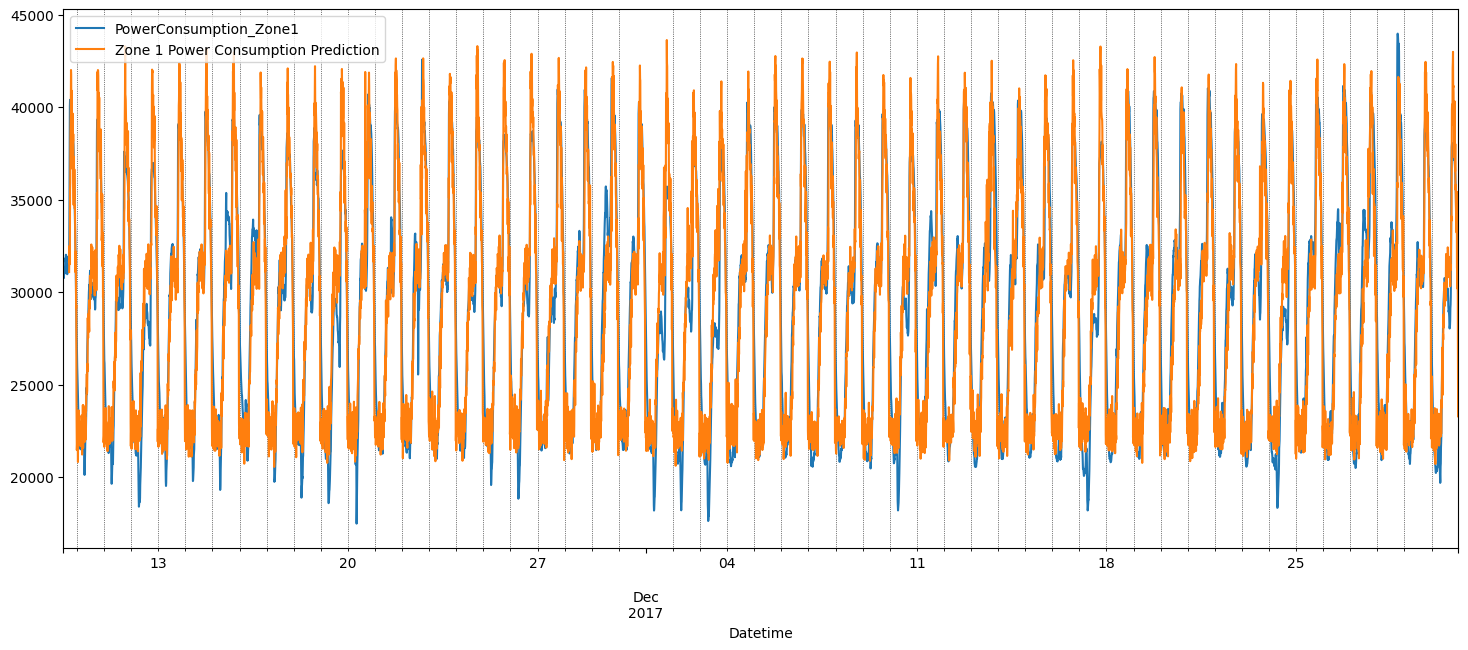

In [124]:
data_df_final.plot(y=["PowerConsumption_Zone1", "Zone 1 Power Consumption Prediction"],figsize=(18,7))
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

In [125]:
print("RMSE:", np.sqrt(mean_squared_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:])))
print("MAPE:", mean_absolute_percentage_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("MAE:", mean_absolute_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("R2: ", r2_score(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("SMAPE: ", smape(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))

RMSE: 2262.915583259654
MAPE: 0.06082136075514122
MAE: 1727.1398141793597
R2:  0.8616818974308672
SMAPE:  0.06141272302953495


В целом сравнимо с LSTM, но немноооожечко похуже.

In [100]:
from torch.nn import functional as F

hidden_dim = 256
n_layers=2

class RNNRegressor(nn.Module):
    def __init__(self):
        super(RNNRegressor, self).__init__()
        self.rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, nonlinearity='relu')
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, X_batch):
        hidden = torch.randn(n_layers, len(X_batch), hidden_dim)
        output, (hidden) = self.rnn(X_batch, (hidden.detach()))
        return self.linear(output[:,-1])

In [101]:
rnn_regressor = RNNRegressor()

rnn_regressor

RNNRegressor(
  (rnn): RNN(5, 256, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = nn.L1Loss()
rnn_regressor = RNNRegressor()
optimizer = Adam(rnn_regressor.parameters(), lr=learning_rate)

TrainModel(rnn_regressor, loss_fn, optimizer, train_loader, test_loader, epochs)

  0%|          | 0/1407 [00:00<?, ?it/s]

100%|██████████| 1407/1407 [00:30<00:00, 45.80it/s]


Train Loss : 0.206
Valid Loss : 0.110


100%|██████████| 1407/1407 [00:31<00:00, 45.01it/s]


Train Loss : 0.169
Valid Loss : 0.100


100%|██████████| 1407/1407 [00:31<00:00, 43.98it/s]


Train Loss : 0.164
Valid Loss : 0.100


100%|██████████| 1407/1407 [00:32<00:00, 43.96it/s]


Train Loss : 0.160
Valid Loss : 0.095


100%|██████████| 1407/1407 [00:32<00:00, 43.41it/s]


Train Loss : 0.158
Valid Loss : 0.095


100%|██████████| 1407/1407 [00:32<00:00, 43.57it/s]


Train Loss : 0.156
Valid Loss : 0.092


100%|██████████| 1407/1407 [00:32<00:00, 43.60it/s]


Train Loss : 0.155
Valid Loss : 0.096


100%|██████████| 1407/1407 [00:32<00:00, 43.21it/s]


Train Loss : 0.154
Valid Loss : 0.092


100%|██████████| 1407/1407 [00:32<00:00, 43.11it/s]


Train Loss : 0.151
Valid Loss : 0.093


100%|██████████| 1407/1407 [00:32<00:00, 43.35it/s]


Train Loss : 0.153
Valid Loss : 0.094


100%|██████████| 1407/1407 [00:32<00:00, 43.43it/s]


Train Loss : 0.151
Valid Loss : 0.102


100%|██████████| 1407/1407 [00:32<00:00, 43.50it/s]


Train Loss : 0.150
Valid Loss : 0.096


100%|██████████| 1407/1407 [00:32<00:00, 43.18it/s]


Train Loss : 0.148
Valid Loss : 0.096


100%|██████████| 1407/1407 [00:32<00:00, 42.90it/s]


Train Loss : 0.148
Valid Loss : 0.095


100%|██████████| 1407/1407 [00:32<00:00, 43.17it/s]


Train Loss : 0.146
Valid Loss : 0.095


In [114]:
test_preds = rnn_regressor(X_test) ## Make Predictions on test dataset
test_preds  = (test_preds*std) + mean

test_preds[:5]

tensor([[30819.1191],
        [32237.3457],
        [31142.3281],
        [30896.8223],
        [32227.5996]], grad_fn=<SliceBackward0>)

In [115]:
data_df_final = df[45000:].copy()

data_df_final["Zone 1 Power Consumption Prediction"] = [None]*lookback + test_preds.detach().numpy().squeeze().tolist()

data_df_final.tail()


,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Zone 1 Power Consumption Prediction
Datetime,,,,,,,,,
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,29200.007812
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,29292.226562
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,26164.828125
2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,23192.792969
2017-12-30 23:50:00,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820,22550.544922


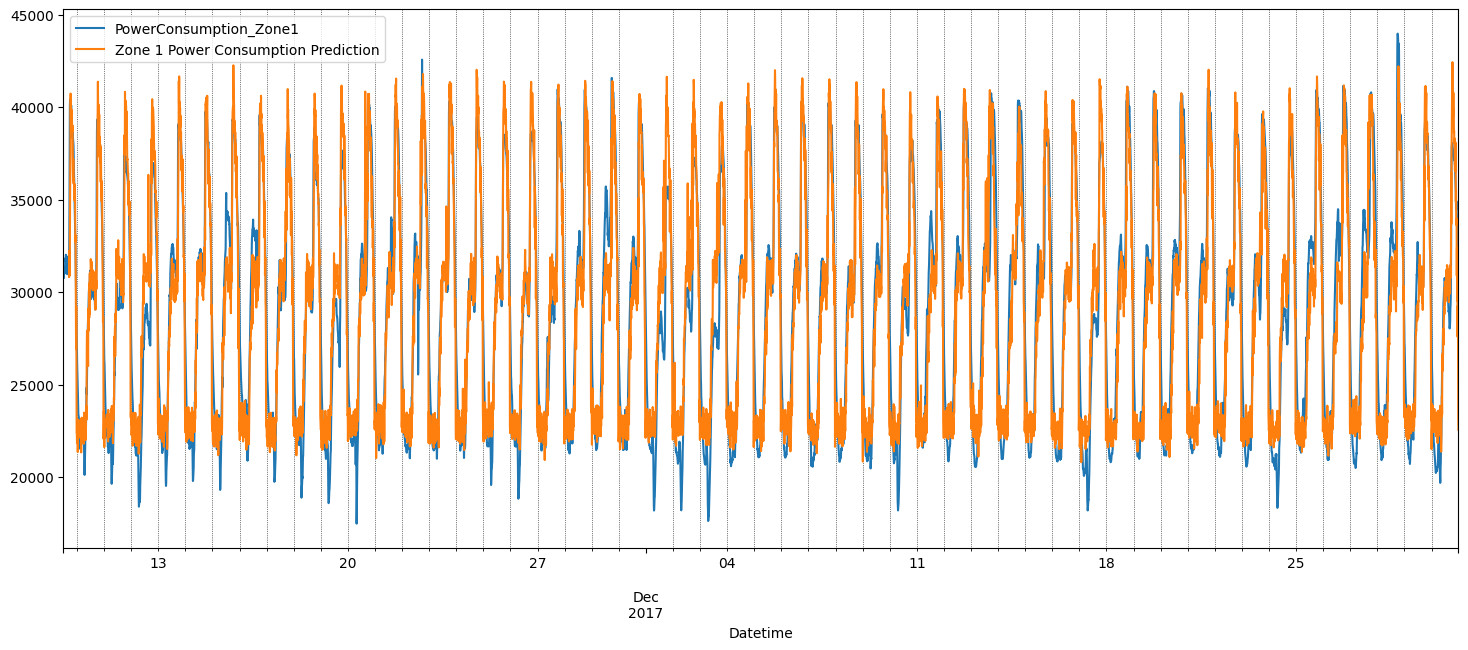

In [116]:
data_df_final.plot(y=["PowerConsumption_Zone1", "Zone 1 Power Consumption Prediction"],figsize=(18,7))
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

In [117]:
print("RMSE:", np.sqrt(mean_squared_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:])))
print("MAPE:", mean_absolute_percentage_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("MAE:", mean_absolute_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("R2: ", r2_score(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("SMAPE: ", smape(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))

RMSE: 2195.188911005001
MAPE: 0.05983947144701575
MAE: 1681.50997582851
R2:  0.8698374294525357
SMAPE:  0.06026177616981652


В целом опять то же самое. Чуть-чуть похуже чем у LSTM но тоже неплохо.

# Классические модели. 

Тут я использовал VAR и RandomForest.

In [75]:
v_train = np.array(df)[:int(0.8*(len(data)))]
v_test = np.array(df)[int(0.8*(len(data))):]

In [76]:
model = VAR(v_train)

Количество лагов для VAR взял очень примерно, но зато какой результат.

In [77]:
model_fitted = model.fit(256)
model_fitted.summary()

C:\Users\k_dys\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\vector_ar\var_model.py:1502: RuntimeWarning: invalid value encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Jan, 2024
Time:                     20:12:26
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    43.8015
Nobs:                     41676.0    HQIC:                   41.4774
Log likelihood:      -1.29864e+06    FPE:                3.52838e+17
AIC:                      40.4042    Det(Omega_mle):     2.40340e+17
--------------------------------------------------------------------
Results for equation y1
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.066241         0.019269           -3.438           0.001
L1.y1           1.292627         0.005678          227.643           0.000
L1.y2          -0.025604         0.000929          -27.555           0.000
L1.y3       

In [85]:
def create_dataset(test, in_seq_order, for_len=1, step=1):
    X_test = []
    Y_test = []
    for i in range(0, len(test) - for_len - in_seq_order, step):
        X_test.append(test[i:(i+in_seq_order)])
        Y_test.append(test[(i+in_seq_order):(i+in_seq_order+for_len)])
    return X_test, Y_test

In [86]:
X_test, Y_test = create_dataset(v_test, 256)
X_train, Y_train = create_dataset(v_train, 256)

In [87]:
Y_pred = []

for i in X_test:
    Y_pred.append(model_fitted.forecast(y=i,steps=1))

In [88]:
Y_pred = np.array(Y_pred)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)

In [90]:
def plot_and_metrics(columns_name, true, pred, train):
    for n in range(len(columns_name)):
        name = columns_name[n]
        Y_true = true[:, :, n]
        Y_pred = pred[:, :, n]
        Y_train = train[:, :, n]

        plt.figure(figsize=(8, 6))
        plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{name} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        print(f"Метрики {name}")
        print("MSE:", mean_squared_error(Y_true, Y_pred))
        print("RMSE:", sqrt(mean_squared_error(Y_true, Y_pred)))
        print("MAE:", mean_absolute_error(Y_true, Y_pred))
        print("SMAPE:", smape(Y_true, Y_pred))
        print("R2:", r2_score(Y_true, Y_pred),"\n")

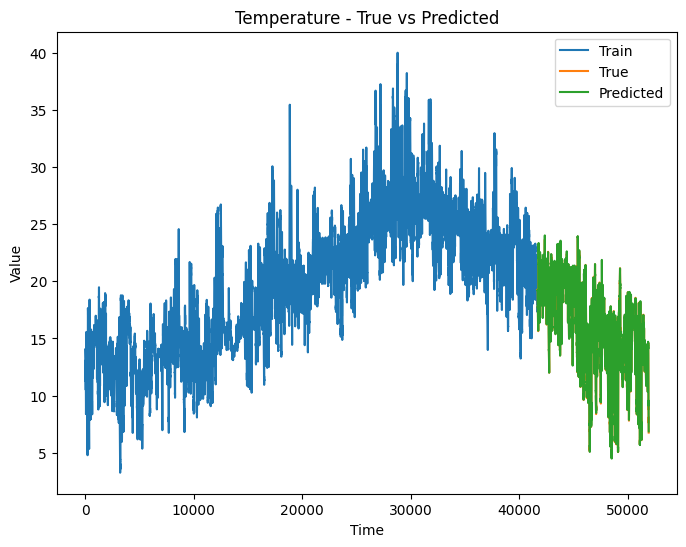

Метрики Temperature
MSE: 0.039513298420146344
RMSE: 0.19877952213481737
MAE: 0.12417308157158652
SMAPE: 0.008816635133274997
R2: 0.9975305498101918 



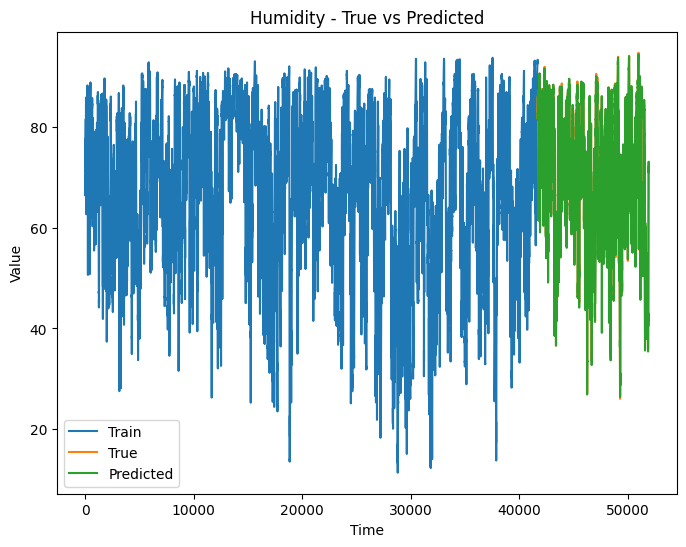

Метрики Humidity
MSE: 1.211540976621558
RMSE: 1.1007002210509262
MAE: 0.6657153535325593
SMAPE: 0.010445712179360127
R2: 0.992805830079365 



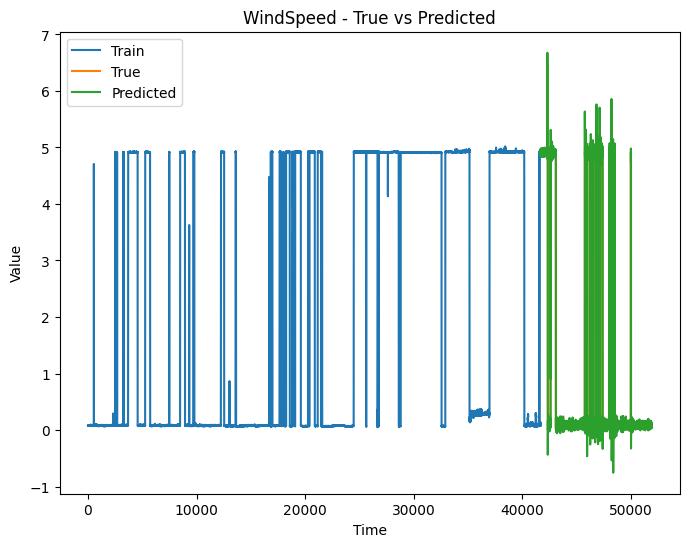

Метрики WindSpeed
MSE: 0.05340659125241599
RMSE: 0.23109866129516196
MAE: 0.056906929194324773
SMAPE: 0.3365517143795942
R2: 0.9871086563443794 



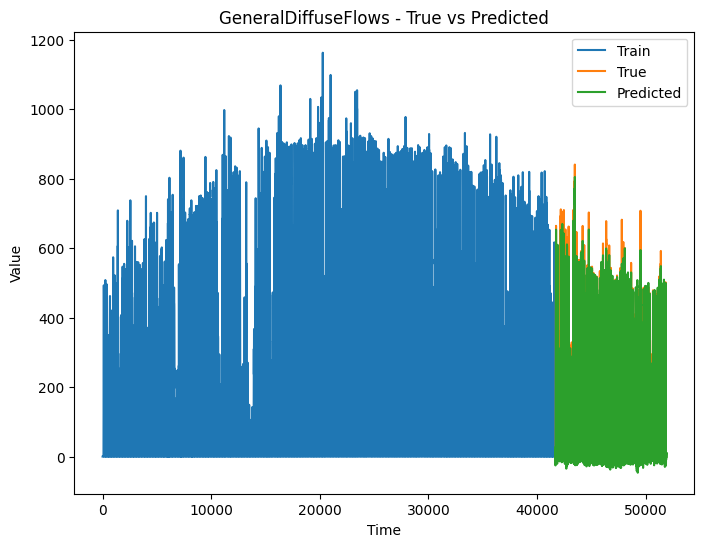

Метрики GeneralDiffuseFlows
MSE: 1322.418792956296
RMSE: 36.36507655644762
MAE: 17.533856169923656
SMAPE: 1.2131378739352594
R2: 0.955046485811636 



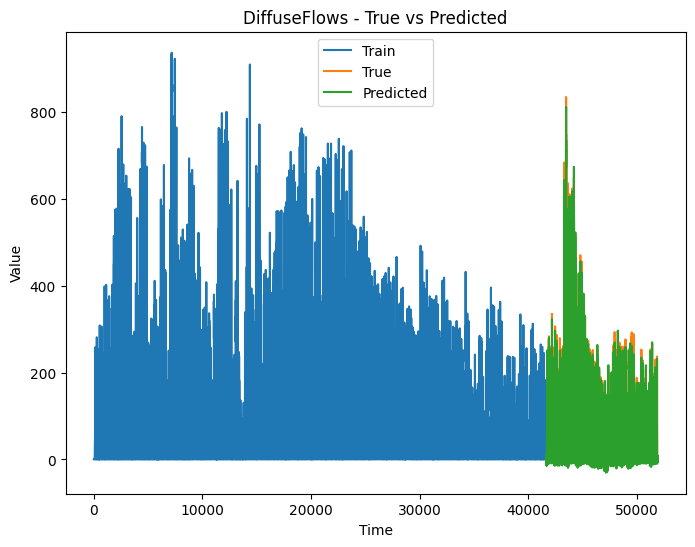

Метрики DiffuseFlows
MSE: 583.3155653345984
RMSE: 24.1519267416618
MAE: 10.907422400116273
SMAPE: 1.1696229102695506
R2: 0.9329493478446234 



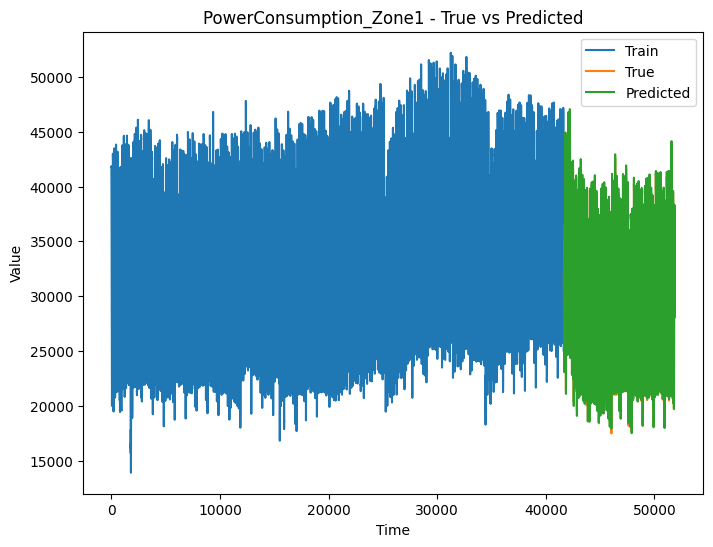

Метрики PowerConsumption_Zone1
MSE: 89924.04091797353
RMSE: 299.87337480672323
MAE: 211.77263452719427
SMAPE: 0.00733367191012879
R2: 0.9975997823719737 



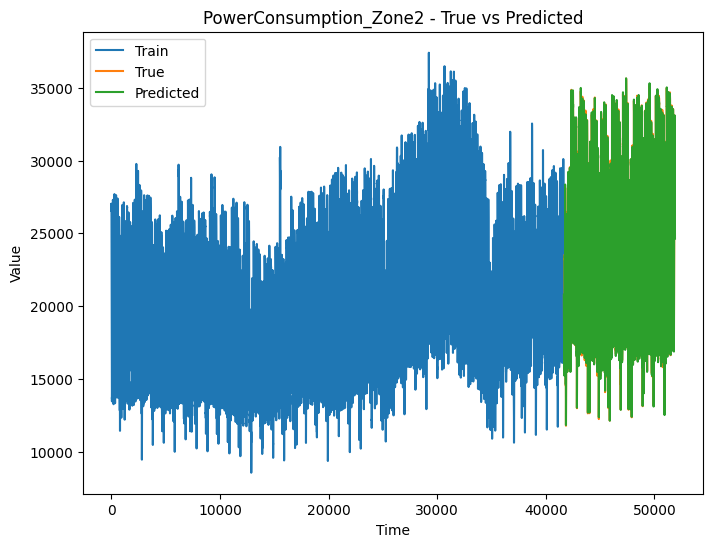

Метрики PowerConsumption_Zone2
MSE: 69495.54255988225
RMSE: 263.62007237667285
MAE: 170.62930225234425
SMAPE: 0.007498976350362553
R2: 0.9977166264574533 



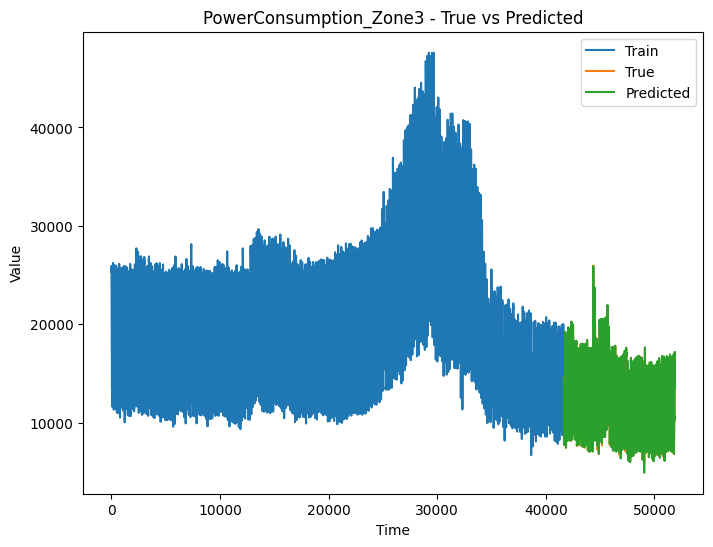

Метрики PowerConsumption_Zone3
MSE: 51240.06869578842
RMSE: 226.36269280910318
MAE: 132.58232134018579
SMAPE: 0.01148992228470513
R2: 0.9952936038733853 



In [91]:
plot_and_metrics(data.columns, Y_test, Y_pred, Y_train)

Этот датасет очень хорошо прогнозируется VARR моделью. ПРичем хорошо прогнозируется не только целевой powerconsumption, но и вообще все составляющие ряды.

Метрики просто отличные - 

R2 - 0,99+, MAE - очень маленький(ну в рамках данных). SMAPE - 1% сказка а не цифры.


# Теперь лесочек

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [15]:
regr = RandomForestRegressor(max_depth=30, random_state=42, criterion = 'absolute_error', verbose=10)

In [16]:
regr.fit(train, tar_train)

building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   10.8s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   43.6s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  1.3min


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:  2.2min


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:  3.1min


building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:  4.4min


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:  5.6min


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  7.2min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  8.9min


building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed: 10.9min


building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed: 12.9min


building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed: 15.3min


building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed: 17.8min


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


RandomForestRegressor(criterion='absolute_error', max_depth=30, random_state=42,
                      verbose=10)

In [17]:
pred = regr.predict(test)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.1s


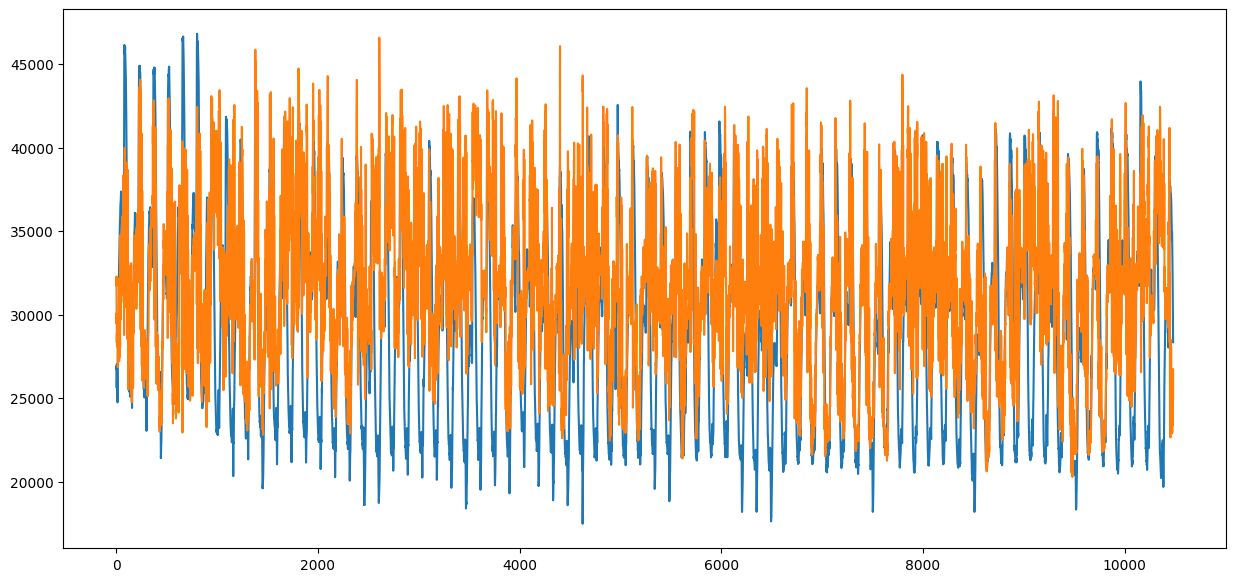

In [18]:
plt.figure(figsize = (15,7))
plt.plot(tar_test)
plt.plot(pred)

In [19]:
print("RMSE:", np.sqrt(mean_squared_error(tar_test, pred)))
print("MAPE:", mean_absolute_percentage_error(tar_test, pred))
print("MAE:", mean_absolute_error(tar_test, pred))
print("R2: ", r2_score(tar_test, pred))
print("SMAPE: ", smape(tar_test, pred))

RMSE: 6738.1322392977445
MAPE: 0.18739568235432713
MAE: 4950.5058840025895
R2:  -0.19396913671847726
SMAPE:  0.16481329634969036


Учился миллион лет, но результаты неутешительные.

Метрики ужасные по сравнению с предыдущими моделями, но тем не менее не скажу что этот датасет совсем не подходит для предсказания лесом.

В датасете есть информация о потреблении энергии за год. И вполне логично что если продлить данные на несколько лет, мы увидим на графике четкую цикличность. Тогда если учить лес на информации за весь год, то другие года оно должно предсказывать очень неплохо.

Ну и так внешне видно что какие-то зависимости оно схватило, например пики совпадают, тк это тоже цикличность но с меньшем интервалом во времени день-ночь.

# Вывод

Лучший результат показала VAR модель, что пожалуй имеет определенный смысл. Изначально предсказываемый ряд и так достаточно походит на авторегрессивный, а мы ещё и пытаемся добавить информацию из другихъ данных.

Нейронные сети справились неплохо, но не идеально, возможно большее количество слоев показало бы себя получше, но оно тогда будет учиться сто лет.

По поводу леса я подробно высказался одним пунктом выше.